# Quasi-bound states in the continuum (qBICs) in symmetry-breaking dielectric metasurfaces

Dielectric metasurfaces, composed of subwavelength nanostructures, have emerged as a transformative platform in nanophotonics due to their ability to precisely manipulate light while maintaining low optical losses. Within this domain, quasi-bound states in the continuum (qBICs) have garnered significant attention for their ability to support ultrasharp resonances with high quality factors. These qBICs arise from symmetry-breaking in the metasurface design, converting otherwise non-radiative modes into accessible, yet highly localized, resonant states. By carefully engineering the symmetry properties of these structures, it is possible to achieve angularly tunable optical responses, opening new avenues for advanced photonic devices such as spectral filters, sensors, and imaging systems.

In this notebook, we investigate the angular response of symmetry-breaking dielectric metasurfaces supporting qBICs, as described in `ACS Photonics 2022, 9(11), 3642–3648.` [DOI: 10.1021/acsphotonics.2c01069](https://doi.org/10.1021/acsphotonics.2c01069). Through simulations of the metasurface transmission spectra at varying incident angles, we analyze the impact of these angles on the spectral shifts of the qBICs. 

<img src="img/metasurface_qbic.png" width="400" alt="Schematic of the metasurface">

Tidy3D offers two approaches for simulating oblique plane waves in periodic structures:

1. Fixed in-plane $k$-vector with Bloch boundaries.
2. Fixed angle mode with periodic boundaries.

While both methods yield identical results at the central source frequency, their behavior can differ significantly for frequencies away from the central one. Understanding these differences is crucial for an accurate simulation. More details are introduced in this dedicated [tutorial](https://www.flexcompute.com/tidy3d/examples/notebooks/BroadbandPlaneWaveWithConstantObliqueIncidentAngle/). In this notebook we will use the second approach as it is more cost-effective and easier to set up. 


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tidy3d as td
import tidy3d.web as web
from tidy3d.plugins.dispersion import FastDispersionFitter

## Simulation Setup

### Basic Parameters

Define the simulation wavelength range from 700 nm to 900 nm.

In [2]:
lda0 = 0.8  # central wavelength
freq0 = td.C_0 / lda0  # central frequency
ldas = np.linspace(0.7, 0.9, 201)  # wavelength range
freqs = td.C_0 / ldas  # frequency range
fwidth = 0.5 * (np.max(freqs) - np.min(freqs))  # width of the source frequency range

The metasurface consists of two elliptical amorphous silicon nanodisks. The geometric parameters of the metasurface are defined by the dimensions and orientation of its constituent elliptical nanodisks. Each nanodisk is characterized by its major axis diameter and minor axis diameter. The thickness of the nanodisks determines their vertical dimension. The rotation angle specifies the orientation of each nanodisk relative to a reference axis. Additionally, the periodicity in the x and y directions governs the size of the unit cell as well as our simulation domain. These parameters collectively determine the optical and physical properties of the metasurface. In this notebook, we use the parameters from the [paper](https://doi.org/10.1021/acsphotonics.2c01069).

In [3]:
h = 0.126  # height of the silicon nanodisk
dx = 0.226  # major axis diameter of the nanodisk
dy = 0.152  # minor axis diameter
px = 0.51  # unit cell size in the x direction
py = 0.265  # unit cell size in the y direction
alpha = np.deg2rad(38)  # rotation angle of the nanodisks

### Define Materials

Pyrex, which has a constant refractive index of 1.47 in the visible range, is used as the substrate. For amorphous silicon, we aim to use the same refractive index as the original paper. We do so by discretizing the refractive index plot from the paper, saving the index data in a .txt file, and using [FastDispersionFitter](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.plugins.dispersion.FastDispersionFitter.html#tidy3d.plugins.dispersion.FastDispersionFitter) to fit it. As the plot shows, the fit of the dispersive refractive index is very good.

Alternatively, one can use the refractive index data from [refractiveindex.info](https://refractiveindex.info) by conveniently using the [from_url](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.plugins.dispersion.DispersionFitter.html#tidy3d.plugins.dispersion.DispersionFitter.from_url) method from the [FastDispersionFitter](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.plugins.dispersion.FastDispersionFitter.html#tidy3d.plugins.dispersion.FastDispersionFitter). 
Tidy3D's [material library](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/material_library.html) also contains amorphous silicon however the supported wavelength range is outside of the wavelength of interest in this case.

Output()

08:30:04 CEST WARNING: Unable to fit with weighted RMS error under              
              'tolerance_rms' of 1e-05                                          

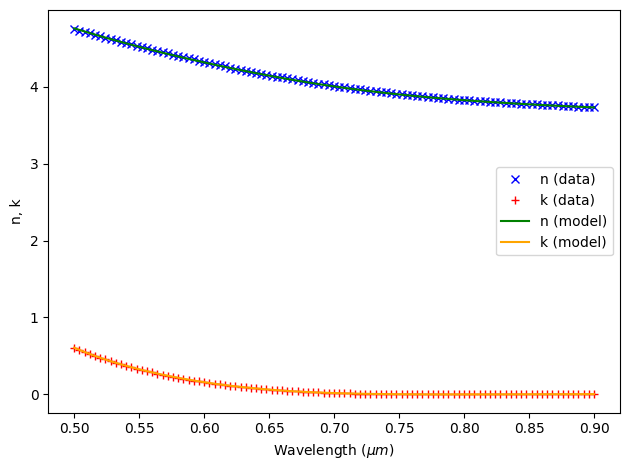

In [4]:
n_pyrex = 1.47  # refractive index of the Pyrex substrate
pyrex = td.Medium(permittivity=n_pyrex**2)

# create a fitter from the refractive index file
fitter = FastDispersionFitter.from_file("misc/amorphous_silicon_from_paper.txt")

# alternatively one can create the fitter object from a refractiveindex.io url
# url = "https://refractiveindex.info/tmp/database/data-nk/main/Si/Pierce.txt"
# fitter = FastDispersionFitter.from_url(url, delimiter="\t")

# fit the data
silicon, error = fitter.fit(max_num_poles=2)
ax = fitter.plot(silicon)
plt.show()

### Create the Nanodisk Structures

To create the rotated elliptical nanodisk structures, we first define a function that takes the geometric parameters of the nanodisk and return the vertices of the ellipse. This can be done by noting that the boundaries of an ellipse can be described by 

$$
X'(\theta) = \frac{b}{2} \cos(\theta),
$$

$$
Y'(\theta) = \frac{a}{2} \sin(\theta),
$$

where $\theta \in [0, 2\pi)$, $a$ and $b$ are the major and minor axis diameters. To rotate the ellipse by an angle $\alpha$ counterclockwise, apply the rotation transformation:

$$
\begin{pmatrix} 
X \\ 
Y 
\end{pmatrix} 
=
\begin{pmatrix} 
x_0 \\ 
y_0 
\end{pmatrix} 
+ 
\begin{pmatrix} 
\cos(\alpha) & -\sin(\alpha) \\ 
\sin(\alpha) & \cos(\alpha) 
\end{pmatrix} 
\begin{pmatrix} 
X'(\theta) \\ 
Y'(\theta) 
\end{pmatrix}.
$$

Substituting $X'(\theta)$ and $Y'(\theta)$:

$$
X(\theta) = x_0 + \frac{b}{2} \cos(\theta) \cos(\alpha) - \frac{a}{2} \sin(\theta) \sin(\alpha),
$$

$$
Y(\theta) = y_0 + \frac{b}{2} \cos(\theta) \sin(\alpha) + \frac{a}{2} \sin(\theta) \cos(\alpha).
$$


In [5]:
def ellipse_vertices(x0, y0, dx, dy, n, alpha):
    """
    Generate N points along the boundary of a rotated ellipse.

    Parameters
    ----------
    x0, y0 : float
        The coordinates of the center of the ellipse.
    dx : float
        The length of the ellipse's major axis.
    dy : float
        The length of the ellipse's minor axis.
    n : int
        The number of points to sample on the ellipse boundary.
    alpha : float
        The rotation angle in radians. alpha=0 means the major axis is aligned
        with the y-axis.

    Returns
    -------
    vertices : list of tuples
        A list of (x, y) coordinates on the ellipse boundary.
    """

    vertices = []
    dtheta = 2.0 * np.pi / n

    for i in range(n):
        theta = i * dtheta
        Xp = (dy / 2.0) * np.cos(theta)
        Yp = (dx / 2.0) * np.sin(theta)

        # Rotate by alpha:
        x = x0 + Xp * np.cos(alpha) - Yp * np.sin(alpha)
        y = y0 + Xp * np.sin(alpha) + Yp * np.cos(alpha)
        vertices.append((x, y))

    return vertices

With the above function defined, we can create each nanodisk structure as [PolySlab](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.PolySlab.html).

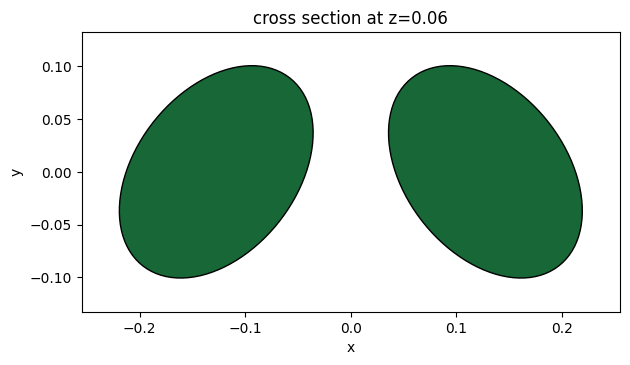

In [6]:
# parameters for the first nanodisk
x0_1 = -px / 4
y0_1 = 0
alpha_1 = -alpha

# parameters for the second nanodisk
x0_2 = px / 4
y0_2 = 0
alpha_2 = alpha

# create the nanodisk structures
n = 100
nanodisk_1 = td.Structure(
    geometry=td.PolySlab(
        vertices=ellipse_vertices(x0_1, y0_1, dx, dy, n, alpha_1), axis=2, slab_bounds=(0, h)
    ),
    medium=silicon,
)

nanodisk_2 = td.Structure(
    geometry=td.PolySlab(
        vertices=ellipse_vertices(x0_2, y0_2, dx, dy, n, alpha_2), axis=2, slab_bounds=(0, h)
    ),
    medium=silicon,
)

# plot the nanodisk structures to verify
ax = nanodisk_1.plot(z=h / 2)
nanodisk_2.plot(z=h / 2, ax=ax)
ax.set_xlim(-px / 2, px / 2)
ax.set_ylim(-py / 2, py / 2)
plt.show()

### Create the Substrate and Monitor

Next we create the Pyrex substrate as a simple [Box](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.Box.html). 

In [7]:
# create the substrate structure
inf_eff = 1e2
substrate = td.Structure(
    geometry=td.Box.from_bounds(rmin=(-inf_eff, -inf_eff, -inf_eff), rmax=(inf_eff, inf_eff, 0)),
    medium=pyrex,
)

To measure the transmission spectrum, we add a [FluxMonitor](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.FluxMonitor.html) below the nanodisks. 

In [8]:
# create a flux monitor to measure the transmission spectrum
monitor_z = -1  # monitor z position
flux_monitor = td.FluxMonitor(
    center=[0, 0, monitor_z], size=[td.inf, td.inf, 0], freqs=freqs, name="flux"
)

### Create Simulation at Given Incident Angle

To facilitate parameter sweeping of the incident angle of the plane wave, we first define a `make_sim(theta)` function that takes the incident angle as input and creates a tidy3d [Simulation](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.Simulation.html) object. In this function, we will create a [PlaneWave](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.PlaneWave.html) source with `angle_theta` set to the incident angle. Importantly, we set `angular_spec=td.FixedAngleSpec()`, which means we will use the fixed angle plane wave source instead of a constant in-plane wavevector source. When this is used, the boundary condition in the $x$ and $y$ directions needs to be periodic instead of bloch. In the $z$ direction, we will simply use the PML boundary. If the simulations diverge, we can use the absorber boundary condition instead. When the absorber is used, it's recommended to use a larger number of layers to effectively minimize the undesired artificial reflection.

To visualize the simulation setup, we create a dummy simulation and plot it in 3D.

In [9]:
run_time = 1e-11  # simulation run time

Lz = 3  # simulation domain size in z


def make_sim(theta):
    """
    Create a simulation with the plane wave incident at an angle theta

    Parameter
    ----------
    theta : float
        The incident angle of the plane wave

    Returns
    -------
    sim : td.Simulation
        A tidy3d simulation
    """

    # create a plane wave source
    source_z = 1  # source z position

    # create an oblique plane wave source
    plane_wave = td.PlaneWave(
        center=[0, 0, source_z],
        size=[td.inf, td.inf, 0],
        source_time=td.GaussianPulse(freq0=freq0, fwidth=fwidth),
        direction="-",
        angle_theta=theta,
        angular_spec=td.FixedAngleSpec(),
    )

    # construct simulation
    sim = td.Simulation(
        size=(px, py, Lz),
        grid_spec=td.GridSpec.auto(min_steps_per_wvl=25, wavelength=lda0),
        structures=[substrate, nanodisk_1, nanodisk_2],
        sources=[plane_wave],
        monitors=[flux_monitor],
        run_time=run_time,
        boundary_spec=td.BoundarySpec(
            x=td.Boundary.periodic(),
            y=td.Boundary.periodic(),
            z=td.Boundary.pml(),
        ),
    )

    return sim


# create a dummy simulation for visualization
sim = make_sim(theta=np.deg2rad(20))
sim.plot_3d()

Before running any simulations, we can inspect the grid around the nanodisks to ensure it's sufficiently fine. This is crucial to capture the accurate resonant behavior of the metasurface. In this case, we use the automatic nonuniform grid of 25 steps per wavelength, which results in about 10 nm minimal grid size.

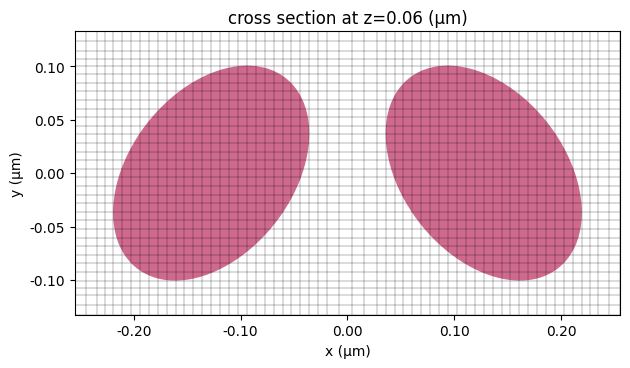

In [10]:
ax = sim.plot(z=h / 2)
sim.plot_grid(z=h / 2, ax=ax)
plt.show()

## Parameter Sweeping the Incident Angle

We now proceed with a parameter sweep of the incident angle ranging from 0 to 16 degrees. For demonstration purposes, we conduct 17 simulations at 1-degree increments. However, to generate a smoother result, similar to Fig. 2 in the paper, a denser sampling of angles would be required.

To perform the simulations in parallel, we construct a dictionary of simulations and subsequently create a [Batch](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.web.api.container.Batch.html) object.

In [11]:
theta_list = np.linspace(0, 16, 17)  # theta values for the parameter sweep

# create a dictionary of simulations
sims = {f"theta={theta:.1f}": make_sim(np.deg2rad(theta)) for theta in theta_list}

# create and run a batch of simulations
batch = web.Batch(simulations=sims)
batch_results = batch.run(path_dir="data")

Output()

08:30:14 CEST Started working on Batch containing 17 tasks.

08:30:30 CEST Maximum FlexCredit cost: 5.072 for the whole batch.

              Use 'Batch.real_cost()' to get the billed FlexCredit cost after   
              the Batch has completed.

Output()

08:41:10 CEST Batch complete.

Output()

After the batch finished, we can check the actual cost of running the batch, which can often be significantly lower than the maximum cost due to early shutoff of the simulations.

In [12]:
real_cost = batch.real_cost()

08:41:29 CEST Total billed flex credit cost: 3.496.

## Extract and Visualize the Transmission Spectra

To extract the transmission spectrum of from each simulation, we can do a quick list comprehension. 

In [13]:
T = np.array(
    [np.abs(batch_results[f"theta={theta:.1f}"]["flux"].flux.values) for theta in theta_list]
)

Next, we plot the transmission as a function of wavelength and incident angle as a false-color map. Here we can clearly see the dispersion of the electric dipole (ED) qBIC mode. Compared to Fig. 2(a) in the referenced paper, the qBIC feature in our results appears slightly less prominent. This discrepancy comes from the difference in the silicon refractive index used, which has a slightly higher loss in this notebook compared to that reported in the paper.

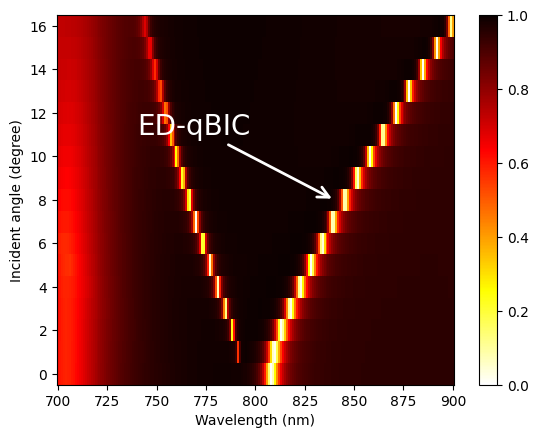

In [14]:
# plot the transmission as a false color image
plt.pcolormesh(1e3 * ldas, theta_list, T, cmap="hot_r", vmin=0, vmax=1)
plt.xlabel("Wavelength (nm)")
plt.ylabel("Incident angle (degree)")

# add text label and arrow in the plot
x_point = 840
y_point = 8
plt.annotate(
    "ED-qBIC",
    xy=(x_point, y_point),
    xytext=(x_point - 100, y_point + 3),
    arrowprops=dict(linewidth=2, edgecolor="white", arrowstyle="->"),
    fontsize=20,
    color="white",
)

plt.colorbar()
plt.show()

## Final Remarks

This notebook aims to demonstrate how to perform broadband simulations with plane waves at a constant incident angle. It only explores one metasurface configuration and one polarization. Different geometries and polarizations can be studied in a similar fashion. 